# Yolo v1 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
customized_path = "/content/drive/My Drive/yolo"
sys.path.append(customized_path)

In [ ]:
# download dataset
#!sh /content/drive/My\ Drive/DeepLearning/yolo/download_data.sh
# copy and place downloaded dataset to your drive. 
#!cp -r /content/VOCdevkit_2007 /content/drive/My\ Drive/DeepLearning/yolo/

--2020-10-17 11:40:14--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2020-10-17 11:40:14--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M   856KB/s    in 10m 1s  

2020-10-17 11:50:16 (748 KB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

URL transformed to HTTPS due to an HSTS policy
--2020-10-17 11:50:17--  https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)

In [ ]:
import os
import random
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name()) # GPU name

Tesla P100-PCIE-16GB


# You Only Look Once: Unified, Real-Time Object Detection 
A list of papper readings:
- [YOLO original paper](https://arxiv.org/pdf/1506.02640.pdf) (recommended)
- [Object detection methods](http://slazebni.cs.illinois.edu/fall18/lec09_detection.pdf) (Slides)
- [Great post about YOLO](https://medium.com/adventures-with-deep-learning/yolo-v1-part-1-cfb47135f81f) on Medium
- [Differences between YOLO, YOLOv2 and YOLOv3
](https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)
- [Great explanation of the Yolo Loss function](https://stats.stackexchange.com/questions/287486/yolo-loss-function-explanation)

We adopt a variant of YOLO, which:
1. Use pretrained ResNet50 classifier as detector backbone. The pretrained model is offered in `torchvision.models`.
2. Instead of using a $7\times7$ detection grid, we use $14\times14$ to get a more finegrained detection.

In [ ]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

## Load the pretrained ResNet classifier
Load the pretrained classifier. By default, it would use the pretrained model provided by `Pytorch`.

In [ ]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


Some basic hyperparameter settings

In [ ]:
learning_rate = 0.001
num_epochs = 60
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 8
lambda_noobj = 0.2

## YOLO-v1 loss 


In general, there are 4 components in the YOLO loss. Consider that we have our prediction grid of size$(N, S, S, 5B+c)$ ( (x, y, w, h, C) for each bounding box, and c is the number of classes), where $N$ is the batch size, $S$ is the grid size, $B$ is the number of bounding boxes. We have :
1. Bounding box regression loss on the bounding box$(x, y, w, h)$
    - $l_{coord}=\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{obj}_{ij}\left[(x_i-\hat{x}_i)^2+(y_i-\hat{y}_i)^2\right]$ + $\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{obj}_{ij}\left[(\sqrt{w_i}-\sqrt{\hat{w}_i})^2+(\sqrt{h_i}-\sqrt{\hat{h}_i})^2\right]$
    - $\mathbb{1}^{obj}_{ij}$: equals to 1 when object appears in cell $i$, and the bounding box $j$ is responsible for the prediction. 0 otherwise.
2. Contain object loss on the confidence prediction $c$ (only calculate for those boxes that actually have objects)
    - $l_{contain}=\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{obj}_{ij}(C_i-\hat{C}_i)^2$
    - $C_i$ the predicted confidence score for cell $i$ from predicted box $j$
    - For each grid cell, you only calculate the contain object loss for the predicted bounding box that has maximum overlap (iou) with the gruond truth box.
    - We say that this predicted box with maximum iou is **responsible** for the prediction.
3. No object loss on the confidence prediction $c$ (only calculate for those boxes that don't have objects)
    - $l_{noobj}=\sum_{i=0}^{S^2}\sum_{j=0}^B\mathbb{1}^{noobj}_{ij}(C_i-\hat{C}_i)^2$
    - $\mathbb{1}^{obj}_{ij}$: equals to 1 when **no object appears** in cell $i$.
4. Classification error loss.
    - $l_{class}=\sum_{i=0}^{S^2}\mathbb{1}_i^{obj}\sum_{c\in classes}\left(p_i(c)-\hat{p_i}(c)\right)^2$
    - $p_i(c)$ is the predicted score for class $c$
    
Putting them together, we get the yolo loss:
\begin{equation}
yolo=\lambda_{coord}l_{coord}+l_{contain}+\lambda_{noobj}l_{noobj}+l_{class}
\end{equation}
where $\lambda$ are hyperparameters. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
 
class YoloLoss(nn.Module):
    def __init__(self,S,B,l_coord,l_noobj):
        super(YoloLoss,self).__init__()
        self.S = S
        self.B = B
        self.l_coord = l_coord#lambda_coord
        self.l_noobj = l_noobj#lambda_noobj
        self.mse_loss = nn.MSELoss(size_average=False, reduce = True)
 
    def compute_iou(self, box1, box2):                                                                                                                                                             
        """Compute the intersection over union of two set of boxes, each box is [x1,y1,x2,y2].
        Args:
          box1: (tensor) bounding boxes, sized [N,4].
          box2: (tensor) bounding boxes, sized [M,4].
        Return:
          (tensor) iou, sized [N,M].
        """
        N = box1.size(0)
        M = box2.size(0)
        
        lt = torch.max(
            box1[:,:2].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,:2].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )   
 
        rb = torch.min(
            box1[:,2:].unsqueeze(1).expand(N,M,2),  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:,2:].unsqueeze(0).expand(N,M,2),  # [M,2] -> [1,M,2] -> [N,M,2]
        )   
 
        wh = rb - lt  # [N,M,2]
        wh[wh<0] = 0  # clip at 0
        #wh[:,:,0]: x coordinate difference, wh[:,:,1]: ycoordinate difference
        inter = wh[:,:,0] * wh[:,:,1]  # [N,M]
 
        #            (x2  -  x1)       *   (y2    -   y1)
        area1 = (box1[:,2]-box1[:,0]) * (box1[:,3]-box1[:,1])  # [N,]
        area2 = (box2[:,2]-box2[:,0]) * (box2[:,3]-box2[:,1])  # [M,]
        area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
        area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]
 
        iou = inter / (area1 + area2 - inter)
        return iou 
    
    def get_class_prediction_loss(self, classes_pred, classes_target):
        """ 
        Parameters:
        classes_pred : (tensor) size (batch_size, S, S, 20)                                                                                                                                        
        classes_target : (tensor) size (batch_size, S, S, 20)
         
        Returns:
        class_loss : scalar
        """
        # class_loss.shape: (batch_size, S, S, 20)
        class_loss = self.mse_loss(classes_pred, classes_target)

        return class_loss
         
    def get_regression_loss(self, box_pred_response, box_target_response):
        """
        Parameters:
        box_pred_response : (tensor) size (-1, 5) [x, y, w, h, C]
        box_target_response : (tensor) size (-1, 5) [x, y, w, h, C]
        Note : -1 corresponds to ravels the tensor into the dimension specified 
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as
         
        Returns:
        reg_loss : scalar
        """
        # 1. loss for localization of cell's center
        localization_loss = self.mse_loss(box_pred_response[:, :2], box_target_response[:, :2])
        #print("localization_loss",localization_loss)

        # 2. loss of bounding box height an weight
        box_pred_response_sqrt = torch.sqrt(box_pred_response)
        box_target_response_sqrt = torch.sqrt(box_target_response)
        box_loss = self.mse_loss(box_pred_response_sqrt[:, 2:4], box_target_response_sqrt[:, 2:4])
        #print("box_loss", box_loss)

        reg_loss = localization_loss + box_loss
        return reg_loss
         
    def get_contain_object_loss(self, box_pred_response, box_target_response_iou):
        """
        Parameters:
        box_pred_response : (tensor) size ( -1 , 5)
        box_target_response_iou : (tensor) size ( -1 , 5)
        Note : -1 corresponds to ravels the tensor into the dimension specified 
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as
         
        Returns:
        contain_loss : scalar
        """
        contain_loss = self.mse_loss(box_pred_response[:,4], box_target_response_iou[:,4])
        return contain_loss
         
    def get_no_object_loss(self, target_tensor, pred_tensor, no_object_mask):
        """                                                                                                                                                                                        
        Parameters:
        target_tensor : (tensor) size (batch_size, S , S, 30)
        pred_tensor : (tensor) size (batch_size, S , S, 30)
        no_object_mask : (tensor) size (batch_size, S , S)
         
        Returns:
        no_object_loss : scalar
         
        Hints:
        1) Create 2 tensors no_object_prediction and no_object_target which only have the 
        values which have no object. 
        2) Have another tensor no_object_prediction_mask of the same size such that 
        mask with respect to both confidences of bounding boxes set to 1. 
        3) Create 2 tensors which are extracted from no_object_prediction and no_object_target using
        the mask created above to find the loss. 
        """
        # select no object value only
        #print("no_object_mask.shape:", no_object_mask.shape)
        #print("pred_tensor.shape:", pred_tensor.shape)
        #no_object_mask.shape: torch.Size([24, 14, 14])
        #pred_tensor.shape: torch.Size([24, 14, 14, 30])

        no_object_prediction = pred_tensor[no_object_mask]
        no_object_target = target_tensor[no_object_mask]
        
        # select confidences value of no object
        #print("no_object_prediction.shape:", no_object_prediction.shape)
        #no_object_prediction.shape: torch.Size([4635, 30])
        no_object_prediction_confidences = no_object_prediction[:, [4,9]]
        no_object_target_confidences = no_object_target[:,[4,9]]

        no_object_loss = self.mse_loss(no_object_prediction_confidences, no_object_target_confidences)

        return no_object_loss
          
    def find_best_iou_boxes(self, box_target, box_pred):
        """
        Parameters: 
        box_target : (tensor)  size (-1, 5)
        box_pred : (tensor) size (-1, 5)
        Note : -1 corresponds to ravels the tensor into the dimension specified 
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as
         
        Returns: 
        box_target_iou: (tensor)
        contains_object_response_mask : (tensor)
         
        1) Find the iou's of each of the 2 bounding boxes of each grid cell of each image.
        2) Set the corresponding contains_object_response_mask of the bounding box with the max iou
        of the 2 bounding boxes of each grid cell to 1.
        3) For finding iou's use the compute_iou function
        4) Before using compute preprocess the bounding box coordinates in such a way that 
        if for a Box b the coordinates are represented by [x, y, w, h] then 
        x, y = x/S - 0.5*w, y/S - 0.5*h ; w, h = x/S + 0.5*w, y/S + 0.5*h
        Note: Over here initially x, y are the center of the box and w,h are width and height. 
        We perform this transformation to convert the correct coordinates into bounding box coordinates.
        5) Set the confidence of the box_target_iou of the bounding box to the maximum iou
        """
        
        contains_object_response_mask = torch.zeros(box_pred.shape).to(device)
        box_target_iou = torch.zeros(box_target.shape).to(device)

        # 2 boxes per batch
        for i in range(0, box_target.shape[0], 2):
              # extract pred box vector
              box_pred_coordinate = box_pred[i:i+2, 0:4]
              # box_pred_coordinate_xy [x1, y1, x2, y2]
              box_pred_coordinate_xy = Variable(torch.FloatTensor(box_pred_coordinate.shape)).to(device)
              box_pred_coordinate_xy.zero_()

              #x = x/S - 0.5*w
              box_pred_coordinate_xy[:,0] = box_pred_coordinate[:, 0]/float(self.S)- 0.5*box_pred_coordinate[:,2]
              # w = x/S + 0.5*w
              box_pred_coordinate_xy[:,2] = box_pred_coordinate[:, 0]/float(self.S)+ 0.5*box_pred_coordinate[:,2]
              #y = y/S - 0.5*h
              box_pred_coordinate_xy[:,1] = box_pred_coordinate[:, 1]/float(self.S)-0.5*box_pred_coordinate[:,3]
              #h = y/S + 0.5*h
              box_pred_coordinate_xy[:,3] = box_pred_coordinate[:, 1]/float(self.S)+0.5*box_pred_coordinate[:,3]      

              # extract target box vector 
              box_target_coordinate = box_target[i:i+2, 0:4]
              box_target_coordinate_xy = Variable(torch.FloatTensor(box_target_coordinate.shape)).to(device)
              box_target_coordinate_xy.zero_()

              #x = x/S - 0.5*w
              box_target_coordinate_xy[:,0] = box_target_coordinate[:, 0]/float(self.S)- 0.5*box_target_coordinate[:,2]
              # w = x/S + 0.5*w
              box_target_coordinate_xy[:,2] = box_target_coordinate[:, 0]/float(self.S)+ 0.5*box_target_coordinate[:,2]
              #y = y/S - 0.5*h
              box_target_coordinate_xy[:,1] = box_target_coordinate[:, 1]/float(self.S)-0.5*box_target_coordinate[:,3]
              #h = y/S + 0.5*h
              box_target_coordinate_xy[:,3] = box_target_coordinate[:, 1]/float(self.S)+0.5*box_target_coordinate[:,3]   

              #print(box_pred_coordinate_xy)
              #tensor([[-0.2402, -0.0701,  0.2849,  0.0958],
              #        [-0.1826, -0.3469,  0.1974,  0.3593]], device='cuda:0',
              #print(box_target_coordinate_xy)
              #############################
              # calculate iou
              iou = self.compute_iou(box_pred_coordinate_xy, box_target_coordinate_xy).to(device)
              max_index, max_value = iou.max(1)[1][0].item(), iou.max(1)[0][0].item()

              contains_object_response_mask[i+max_index, :] = 1
              box_target_iou[i+max_index, :] = max_value
              
        return box_target_iou, contains_object_response_mask
         
    def forward(self, pred_tensor,target_tensor):
        '''
        pred_tensor: (tensor) size(batchsize,S,S,Bx5+20=30)
                      where B - number of bounding boxes this grid cell is a part of = 2
                            5 - number of bounding box values corresponding to [x, y, w, h, c]
                                where x - x_coord, y - y_coord, w - width, h - height, c - confidence of having an object
                            20 - number of classes
         
        target_tensor: (tensor) size(batchsize,S,S,30)
         
        Returns:
        Total Loss
        '''
        N = pred_tensor.size(0)
         
        total_loss = None
        # Create 2 tensors contains_object_mask and no_object_mask 
        # of size (Batch_size, S, S) such that each value corresponds to if the confidence of having 
        # an object > 0 in the target tensor.

        ##### CODE #####
        contains_object_mask = (target_tensor[:, :, :, 4].bool()>0) | (target_tensor[:, :, :, 9].bool()>0).to(device)
        contains_object_mask_squeeze = contains_object_mask[:]
        #print(contains_object_mask)
        contains_object_mask = contains_object_mask.unsqueeze(-1).expand(target_tensor.shape).to(device)
        #print("unsqueeze: ",contains_object_mask.shape)

        no_object_mask = (target_tensor[ :, :, :,4].bool()==0) &  (target_tensor[ :, :, :,9].bool()==0).to(device)
        no_object_mask_squeeze = no_object_mask[:]
        #print("no_object_mask.shape:", no_object_mask.shape)
        no_object_mask = no_object_mask.unsqueeze(-1).expand(target_tensor.shape).to(device)
        #print("After unsqueeze: ",contains_no_object_mask)


        ##### CODE #####
        """
        Create a tensor contains_object_pred that corresponds to 
        to all the predictions which seem to confidence > 0 for having an object
        Then, split this tensor into 2 tensors :                                                                                                                                                       
        1) bounding_box_pred : Contains all the Bounding box predictions (x, y, w, h, c) of all grid 
                                cells of all images
        2) classes_pred : Contains all the class predictions for each grid cell of each image
        Hint : Use contains_object_mask
        """ 
        ##### CODE #####
        contains_object_pred = pred_tensor[contains_object_mask].reshape(-1, target_tensor.shape[-1])
        contains_object_pred.to(device)
        #print(contains_object_pred)
        
        #split the contains_object_pred tensor
        bounding_box_pred = contains_object_pred[:, :10].reshape(-1, 5)
        bounding_box_pred.to(device)
        
        classes_pred = contains_object_pred[:, 10:].reshape(-1, 20)
        classes_pred.to(device)  
        ##### CODE #####                   
        """
        # Similarly, create 2 tensors bounding_box_target and classes_target
        # using the contains_object_mask.
        """
        ##### CODE #####
        # apply mask
        contains_object_target = target_tensor[contains_object_mask].reshape(-1, target_tensor.shape[-1])
        contains_object_target.to(device)

        # split tensor
        bounding_box_target = contains_object_target[:, :10].reshape(-1, 5)
        bounding_box_target.to(device)

        classes_target = contains_object_target[:, 10:].reshape(-1, 20)
        classes_target.to(device)
        ##### CODE #####
        
        #Compute the No object loss here
        # Instruction: finish your get_no_object_loss
        ##### CODE #####
        no_object_loss = self.get_no_object_loss(target_tensor, pred_tensor, no_object_mask_squeeze)
        #no_object_loss = self.get_no_object_loss(target_tensor, pred_tensor, no_object_mask)
        ##### CODE #####
        """
        # Compute the iou's of all bounding boxes and the mask for which bounding box 
        # of 2 has the maximum iou the bounding boxes for each grid cell of each image.
        # Instruction: finish your find_best_iou_boxes and use it.
        """
        ##### CODE #####
        box_target_iou, coo_response_mask = self.find_best_iou_boxes(bounding_box_target, bounding_box_pred)
        box_target_iou = box_target_iou.to(device)
        coo_response_mask = coo_response_mask.bool().to(device)
        ##### CODE #####
        """        
        # Create 3 tensors :
        # 1) box_prediction_response - bounding box predictions for each grid cell which has the maximum iou
        # 2) box_target_response_iou - bounding box target ious for each grid cell which has the maximum iou
        # 3) box_target_response -  bounding box targets for each grid cell which has the maximum iou
        # Hint : Use coo_response_mask
        """
        ##### CODE #####
        box_prediction_response = bounding_box_pred[coo_response_mask].reshape(-1,5)
        box_target_response_iou = box_target_iou[coo_response_mask].reshape(-1,5)
        box_target_response = bounding_box_target[coo_response_mask].reshape(-1,5)

        box_prediction_response = box_prediction_response.to(device)
        box_target_response_iou = box_target_response_iou.to(device)
        box_target_response = box_target_response.to(device)
        ##### CODE #####
        """
        # Find the class_loss, containing object loss and regression loss
        """
        ##### CODE #####
        class_prediction_loss = self.get_class_prediction_loss(classes_pred, classes_target)
        regression_loss = self.get_regression_loss(box_prediction_response, box_target_response)
        contain_object_loss = self.get_contain_object_loss(box_prediction_response, box_target_response_iou)

        total_loss = lambda_coord*regression_loss + contain_object_loss + lambda_noobj*no_object_loss + class_prediction_loss
        ##### CODE #####
        return total_loss / N

Initialize YoloLoss and optimzer

In [ ]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
print("lambda_coord:", lambda_coord,";  lambda_noobj:",lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

lambda_coord: 8 ;  lambda_noobj: 0.2


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) generated by a combination of the train and val splits to train our detector. 

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is a $(S, S, 5B+c)$ tensor, we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [ ]:
file_root_train = customized_path_to_homework + '/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = customized_path_to_homework + '/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [ ]:
file_root_test = customized_path_to_homework + '/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = customized_path_to_homework + '/voc2007test.txt'

print(annotation_file_test)
test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

## Train detector
Now, train your detector.

In [ ]:
print("batch_size,",batch_size)

batch_size, 24


In [ ]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(tqdm(train_loader, total=len(train_loader))):
        images, target = images.to(device), target.to(device)

        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch [%d/%d], average_loss: %.4f'
            % (epoch+1, num_epochs, total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(tqdm(test_loader, total=len(test_loader))):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')

  0%|          | 0/209 [00:00<?, ?it/s]

batch_size, 24


Starting epoch 1 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [1/60], average_loss: 11.3792


100%|██████████| 207/207 [01:12<00:00,  2.87it/s]


Updating best test loss: 6.78054


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 2 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [2/60], average_loss: 5.9656


100%|██████████| 207/207 [01:12<00:00,  2.87it/s]


Updating best test loss: 5.53970


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 3 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [3/60], average_loss: 5.0903


100%|██████████| 207/207 [01:12<00:00,  2.87it/s]


Updating best test loss: 5.15700


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 4 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [4/60], average_loss: 4.6653


100%|██████████| 207/207 [01:11<00:00,  2.88it/s]


Updating best test loss: 4.76692


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 5 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [5/60], average_loss: 4.3282


100%|██████████| 207/207 [01:11<00:00,  2.88it/s]


Updating best test loss: 4.54037


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 6 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [6/60], average_loss: 4.1176


100%|██████████| 207/207 [01:12<00:00,  2.87it/s]


Updating best test loss: 4.28080


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 7 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [7/60], average_loss: 3.8469


100%|██████████| 207/207 [01:11<00:00,  2.88it/s]


Updating best test loss: 4.01968


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 8 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [8/60], average_loss: 3.6188


100%|██████████| 207/207 [01:10<00:00,  2.92it/s]


Updating best test loss: 3.92932


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 9 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [9/60], average_loss: 3.4811


100%|██████████| 207/207 [01:10<00:00,  2.93it/s]


Updating best test loss: 3.85135


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 10 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [10/60], average_loss: 3.3549


100%|██████████| 207/207 [01:10<00:00,  2.93it/s]


Updating best test loss: 3.77552


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 11 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [11/60], average_loss: 3.2003


100%|██████████| 207/207 [01:10<00:00,  2.93it/s]


Updating best test loss: 3.61207


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 12 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [12/60], average_loss: 3.0900


100%|██████████| 207/207 [01:10<00:00,  2.92it/s]


Updating best test loss: 3.56315


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 13 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [13/60], average_loss: 3.0059


100%|██████████| 207/207 [01:10<00:00,  2.94it/s]


Updating best test loss: 3.45571


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 14 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [14/60], average_loss: 2.8951


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 15 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [15/60], average_loss: 2.8367


100%|██████████| 207/207 [01:10<00:00,  2.93it/s]


Updating best test loss: 3.45228


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 16 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [16/60], average_loss: 2.7342


100%|██████████| 207/207 [01:10<00:00,  2.94it/s]


Updating best test loss: 3.37586


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 17 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [17/60], average_loss: 2.6934


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 18 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [18/60], average_loss: 2.6301


100%|██████████| 207/207 [01:11<00:00,  2.91it/s]


Updating best test loss: 3.34510


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 19 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [19/60], average_loss: 2.5680


100%|██████████| 207/207 [01:11<00:00,  2.89it/s]


Updating best test loss: 3.33965


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 20 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [20/60], average_loss: 2.5247


100%|██████████| 207/207 [01:11<00:00,  2.90it/s]


Updating best test loss: 3.30144


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 21 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [21/60], average_loss: 2.4776


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 22 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [22/60], average_loss: 2.4204


100%|██████████| 207/207 [01:11<00:00,  2.91it/s]


Updating best test loss: 3.24286


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 23 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [23/60], average_loss: 2.3593


100%|██████████| 207/207 [01:10<00:00,  2.92it/s]


Updating best test loss: 3.23742


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 24 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [24/60], average_loss: 2.2940


100%|██████████| 207/207 [01:10<00:00,  2.94it/s]


Updating best test loss: 3.20862


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 25 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [25/60], average_loss: 2.2740


100%|██████████| 207/207 [01:11<00:00,  2.90it/s]


Updating best test loss: 3.17770


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 26 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [26/60], average_loss: 2.2314


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 27 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [27/60], average_loss: 2.1781


100%|██████████| 207/207 [01:08<00:00,  3.00it/s]


Updating best test loss: 3.15580


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 28 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [28/60], average_loss: 2.1747


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 29 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [29/60], average_loss: 2.0992


100%|██████████| 207/207 [01:08<00:00,  3.02it/s]


Updating best test loss: 3.14950


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 30 / 60
Learning Rate for this epoch: 0.001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [30/60], average_loss: 2.0905


100%|██████████| 207/207 [01:08<00:00,  3.03it/s]


Updating best test loss: 3.14320


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 31 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [31/60], average_loss: 1.9622


100%|██████████| 207/207 [01:08<00:00,  3.04it/s]


Updating best test loss: 3.00302


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 32 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [32/60], average_loss: 1.9523


100%|██████████| 207/207 [01:08<00:00,  3.01it/s]


Updating best test loss: 2.98014


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 33 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [33/60], average_loss: 1.8455


100%|██████████| 207/207 [01:08<00:00,  3.03it/s]


Updating best test loss: 2.95696


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 34 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [34/60], average_loss: 1.8501


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 35 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [35/60], average_loss: 1.8246


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 36 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [36/60], average_loss: 1.8200


100%|██████████| 207/207 [01:08<00:00,  3.02it/s]


Updating best test loss: 2.94052


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 37 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [37/60], average_loss: 1.8155


100%|██████████| 207/207 [01:08<00:00,  3.02it/s]


Updating best test loss: 2.93956


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 38 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [38/60], average_loss: 1.7937


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 39 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [39/60], average_loss: 1.7882


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 40 / 60
Learning Rate for this epoch: 0.0001


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [40/60], average_loss: 1.7623


100%|██████████| 207/207 [01:08<00:00,  3.02it/s]


Updating best test loss: 2.93286


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 41 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [41/60], average_loss: 1.7682


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 42 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [42/60], average_loss: 1.7479


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 43 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [43/60], average_loss: 1.7250


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 44 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [44/60], average_loss: 1.7541


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 45 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [45/60], average_loss: 1.7328


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 46 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [46/60], average_loss: 1.7285


100%|██████████| 207/207 [01:08<00:00,  3.04it/s]


Updating best test loss: 2.92719


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 47 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [47/60], average_loss: 1.7179


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 48 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [48/60], average_loss: 1.7358


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 49 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [49/60], average_loss: 1.7599


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 50 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [50/60], average_loss: 1.7058


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 51 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [51/60], average_loss: 1.7403


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 52 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [52/60], average_loss: 1.7383


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 53 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [53/60], average_loss: 1.7515


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 54 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [54/60], average_loss: 1.7034


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 55 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [55/60], average_loss: 1.7210


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 56 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [56/60], average_loss: 1.7306


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 57 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [57/60], average_loss: 1.7162


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 58 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [58/60], average_loss: 1.7403


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 59 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [59/60], average_loss: 1.7118


  0%|          | 0/209 [00:00<?, ?it/s]



Starting epoch 60 / 60
Learning Rate for this epoch: 1e-05


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch [60/60], average_loss: 1.7219


100%|██████████| 207/207 [01:08<00:00,  3.02it/s]


# View example predictions

Now, take a glance at how your detector works:

In [ ]:
from eval_voc import evaluate
from predict import predict_image

predicting...
(375, 500, 3)


/content/drive/My Drive/Assignment_3/predict.py:99: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  ids = (ovr<=threshold).nonzero().squeeze()


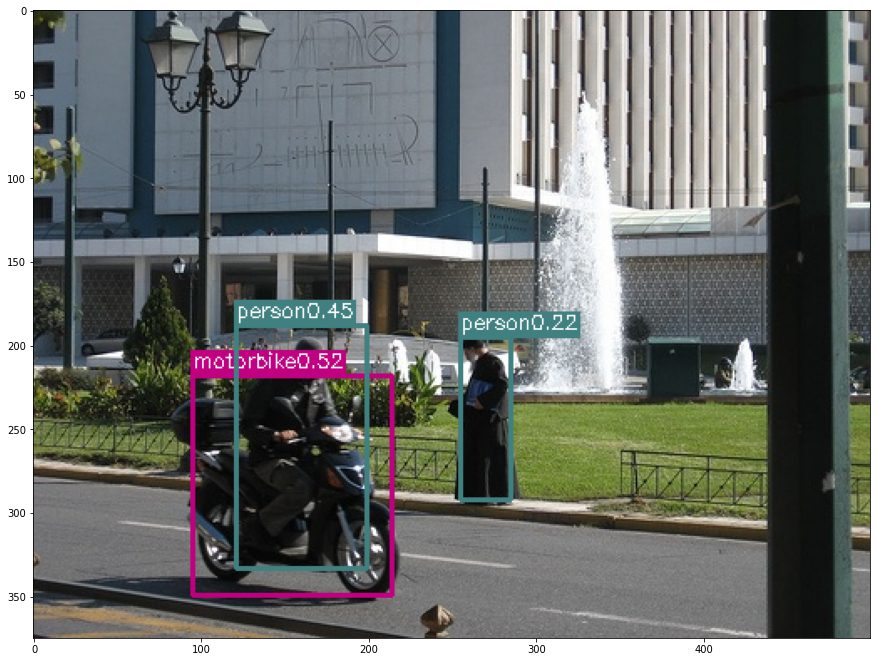

In [ ]:
net.eval()
net.load_state_dict(torch.load('best_detector.pth'))
# select random image from train set
image_name = random.choice(train_dataset.fnames)
image = cv2.imread(os.path.join(file_root_train, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
threshold = 0.1
print('predicting...')
print(image.shape)
result = predict_image(net, image_name, root_img_directory=file_root_train, threshold=threshold)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)

## Evaluate on Test 

To evaluate detection results we use mAP (mean of average precision over each class)

In [ ]:
# 10/17 17:41
test_aps = evaluate(net, test_dataset_file=annotation_file_test, threshold=threshold)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:18<00:00, 35.80it/s]


---class aeroplane ap 0.2626427849105902---
---class bicycle ap 0.49366444556698524---
---class bird ap 0.38785970638910716---
---class boat ap 0.22919371725001106---
---class bottle ap 0.22080651641326254---
---class bus ap 0.3883039802043946---
---class car ap 0.4037491370362604---
---class cat ap 0.41964223543984003---
---class chair ap 0.21291865223399864---
---class cow ap 0.4040579895644241---
---class diningtable ap 0.3024435736349429---
---class dog ap 0.21879717221042355---
---class horse ap 0.5122719760773271---
---class motorbike ap 0.4651035423821631---
---class person ap 0.5606226631388624---
---class pottedplant ap 0.19749405253759242---
---class sheep ap 0.3798558374405528---
---class sofa ap 0.40508753784665014---
---class train ap 0.564818596212334---
---class tvmonitor ap 0.3926588170654919---
---map 0.37109964667776063---
